<a href="https://colab.research.google.com/github/davidgonveg/price_forecasting/blob/main/Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Price Forecasting Model

## First, installing and loading the necessary libraries

In [1]:
!pip install scalecast --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.8 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.7-py3-none-any.whl size=125885 sha256=321e2f149d593ac8cffda2919194779c309f7d57496cb2eaf570305dfe29ffad
  Stored in directory: /root/.cache/pip/wheels/96/45/e9/412ce9a9b95fd79732b3dc8954b81c8dc3c02b37e7bab910e1
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Unin

In [2]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.Forecaster import Forecaster

## We load the data from kaggle. To do this, we enter our token, download the compressed data, decompress it and put it in a DataFrame.

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Load the kaggle token
from google.colab import files

files.upload()

In [5]:
# Create a directory for the kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download the dataset
!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs

100% 492M/492M [00:24<00:00, 21.3MB/s]
100% 492M/492M [00:24<00:00, 21.1MB/s]


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Create a directory for the dataset to be unzip
!mkdir my_dataset

# Unzip the data
!unzip /content/price-volume-data-for-all-us-stocks-etfs.zip -d my_dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: my_dataset/Stocks/ergf.us.txt  
  inflating: my_dataset/Stocks/erh.us.txt  
  inflating: my_dataset/Stocks/eri.us.txt  
  inflating: my_dataset/Stocks/eric.us.txt  
  inflating: my_dataset/Stocks/erie.us.txt  
  inflating: my_dataset/Stocks/erii.us.txt  
  inflating: my_dataset/Stocks/erj.us.txt  
  inflating: my_dataset/Stocks/erm.us.txt  
  inflating: my_dataset/Stocks/ern.us.txt  
  inflating: my_dataset/Stocks/eros.us.txt  
  inflating: my_dataset/Stocks/eryp.us.txt  
  inflating: my_dataset/Stocks/es.us.txt  
  inflating: my_dataset/Stocks/esba.us.txt  
  inflating: my_dataset/Stocks/esbk.us.txt  
  inflating: my_dataset/Stocks/esca.us.txt  
  inflating: my_dataset/Stocks/esdi.us.txt  
  inflating: my_dataset/Stocks/esdiw.us.txt  
  inflating: my_dataset/Stocks/ese.us.txt  
  inflating: my_dataset/Stocks/esea.us.txt  
  inflating: my_dataset/Stocks/eses.us.txt  
  inflating: my_dataset/Stocks/esg.us.txt  
  

In [9]:
data_source = 'kaggle' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '<your API key>'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('my_dataset/Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


Loaded data from the Kaggle repository


# Preliminary visualization of the data

## Check what kind of data do we have here.

In [10]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()


,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


## As we have several columns of prices, we average them to make a simpler and more visual representation of the data.

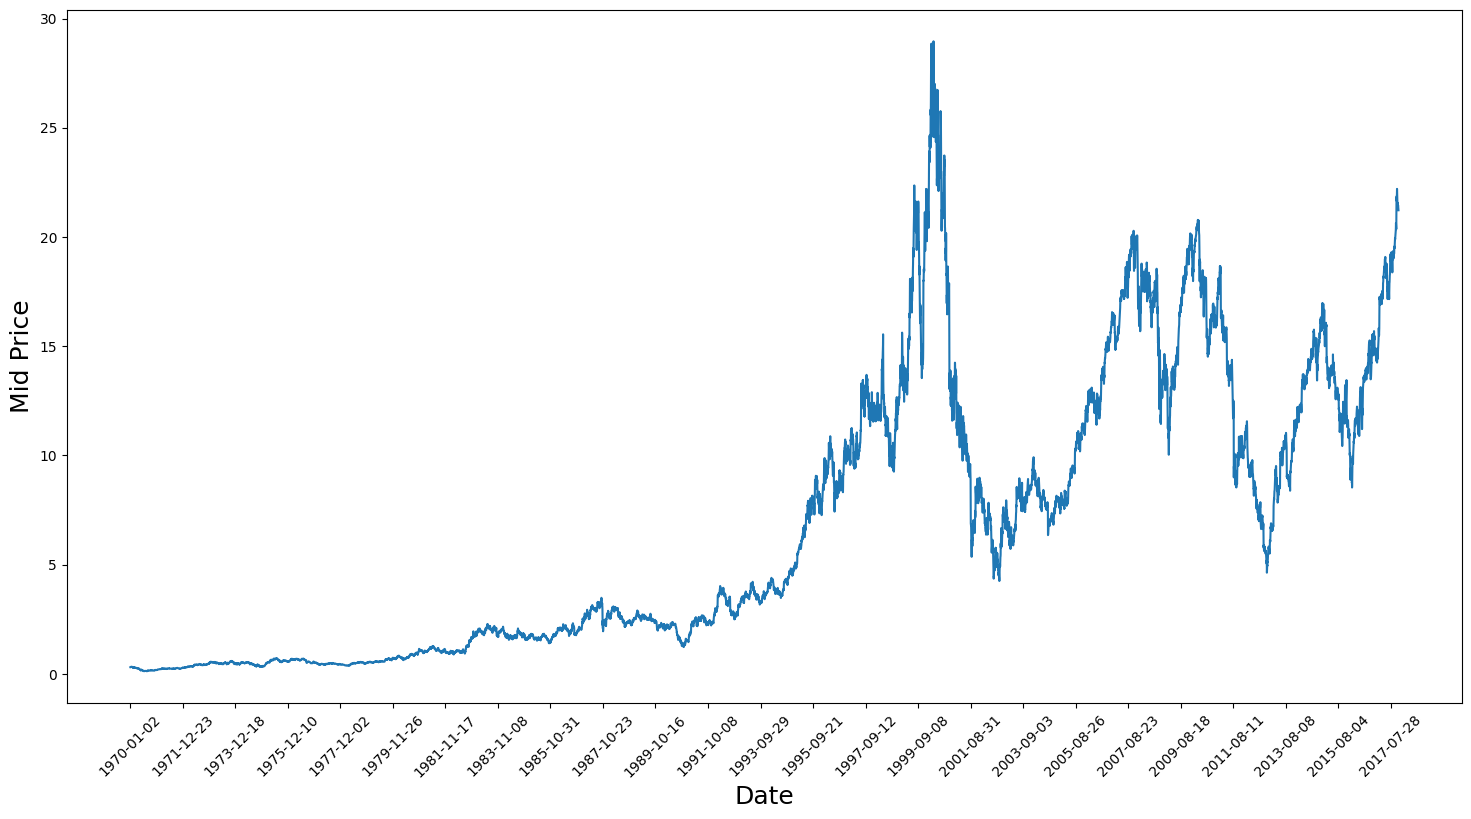

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


Calculate de average price and we made the data split into train and test.

In [12]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0


In [13]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [14]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


## We train the Scaler. To do this, as there is a large variation in the data and we can have a smoother adjustment, we divide the train set into smaller pieces that we will train separately.

In [15]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Data normalization

In [16]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [17]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


# Model

## Model based on the mean

In [18]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00418


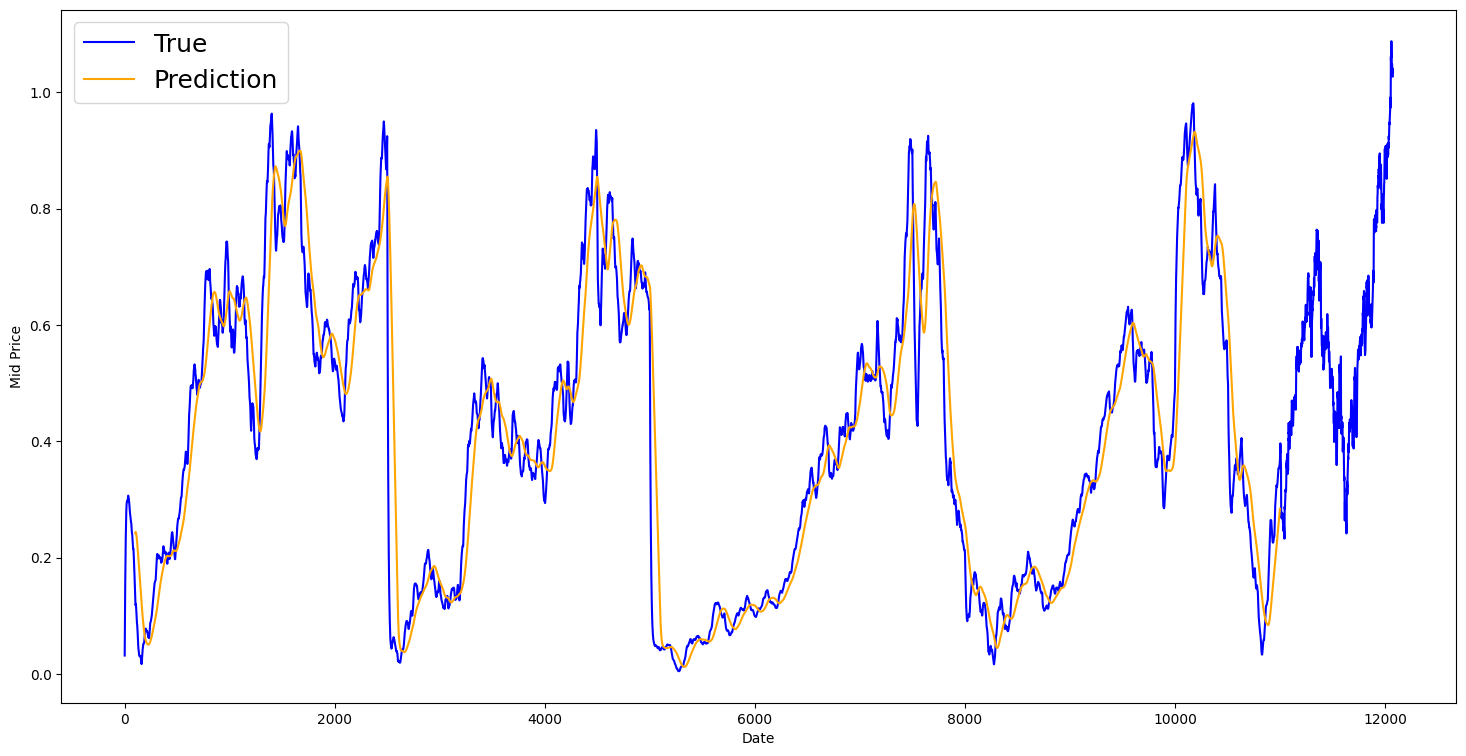

In [19]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


Exponential Average

In [20]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00003


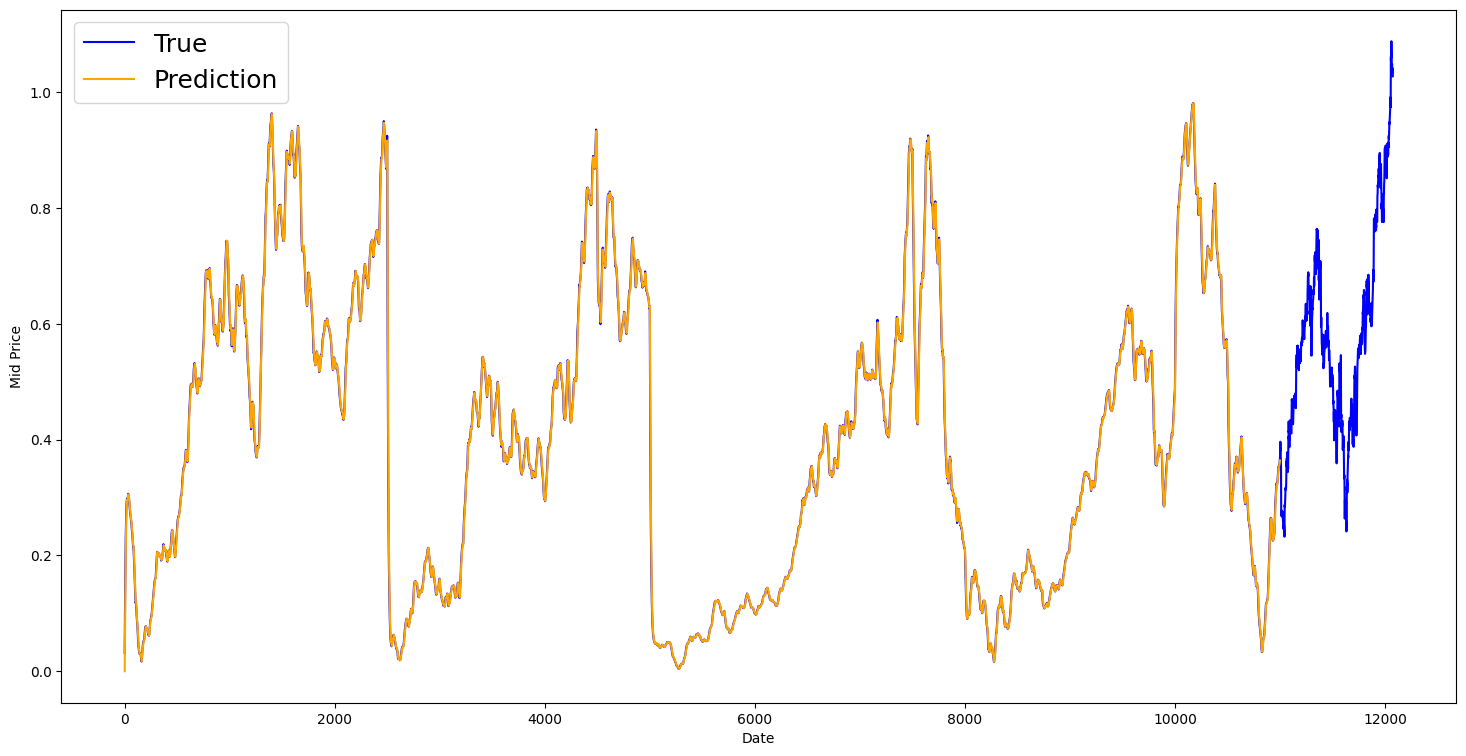

In [21]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


# Model based on LSTMs

In [22]:
df

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385
...,...,...,...,...,...
12070,2017-11-06,21.47000,21.53000,21.38000,21.44000
12071,2017-11-07,21.47000,21.47000,21.32000,21.38000
12072,2017-11-08,21.34000,21.47000,21.24000,21.42000
12073,2017-11-09,21.27000,21.40000,21.15000,21.34000


In [23]:
train_data.shape[0]

11000

##We are going to test different configurations of our Forecasting, with different hyperparameters. We will first test LSTM and then compare the best model with Multiple Linear Regression (MLR).

In [24]:
f = Forecaster(
    y=all_mid_data,
    current_dates=df['Date'])

len(df['Date'])

12075

In [25]:
f.set_test_length(400)       # 1. 400 observations to test the results
f.generate_future_dates(400) # 2. 400 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

1/1 [==============================] - 1s 758ms/step


365/365 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

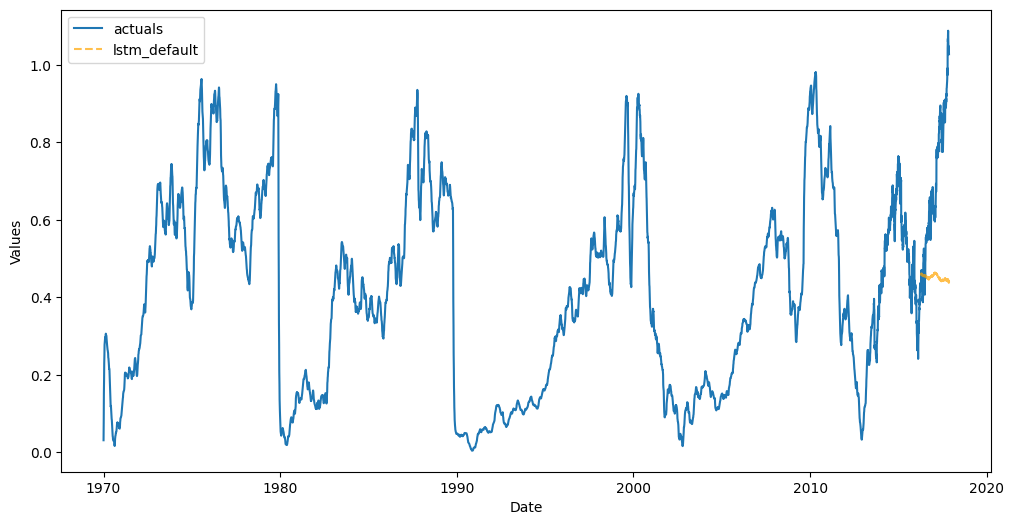

In [26]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

365/365 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

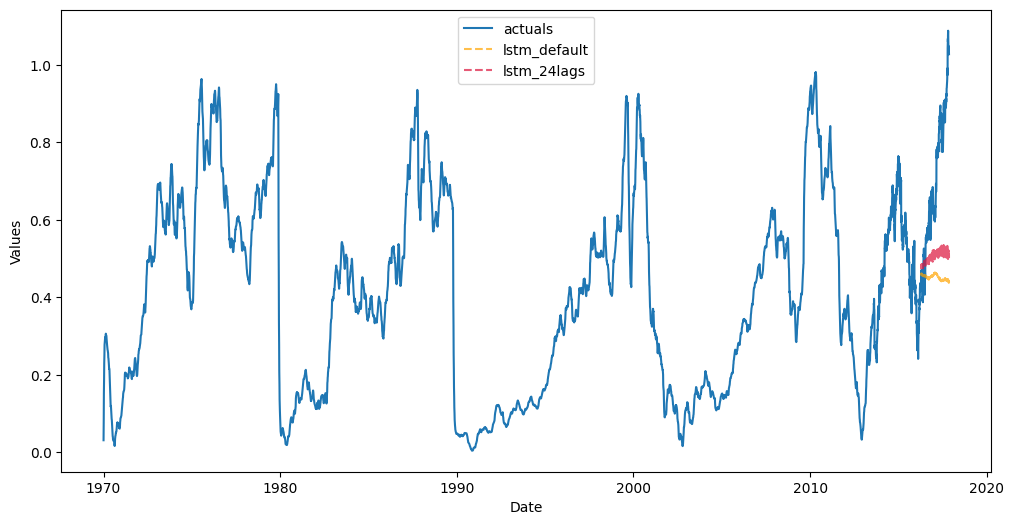

In [27]:
f.manual_forecast(call_me='lstm_24lags',lags=24)
f.plot_test_set(ci=True)

Epoch 1/5
282/282 [==============================] - 4s 9ms/step - loss: 0.1761 - val_loss: 0.1686
Epoch 2/5
282/282 [==============================] - 2s 7ms/step - loss: 0.1283 - val_loss: 0.1649
Epoch 3/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1279 - val_loss: 0.1631
Epoch 4/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1266 - val_loss: 0.1593
Epoch 5/5
1/1 [==============================] - 0s 321ms/step
Epoch 1/5
292/292 [==============================] - 4s 8ms/step - loss: 0.1590 - val_loss: 0.1595
Epoch 2/5
292/292 [==============================] - 3s 9ms/step - loss: 0.1135 - val_loss: 0.1571
Epoch 3/5
292/292 [==============================] - 3s 9ms/step - loss: 0.1122 - val_loss: 0.1540
Epoch 4/5
292/292 [==============================] - 2s 8ms/step - loss: 0.1110 - val_loss: 0.1499
Epoch 5/5
365/365 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

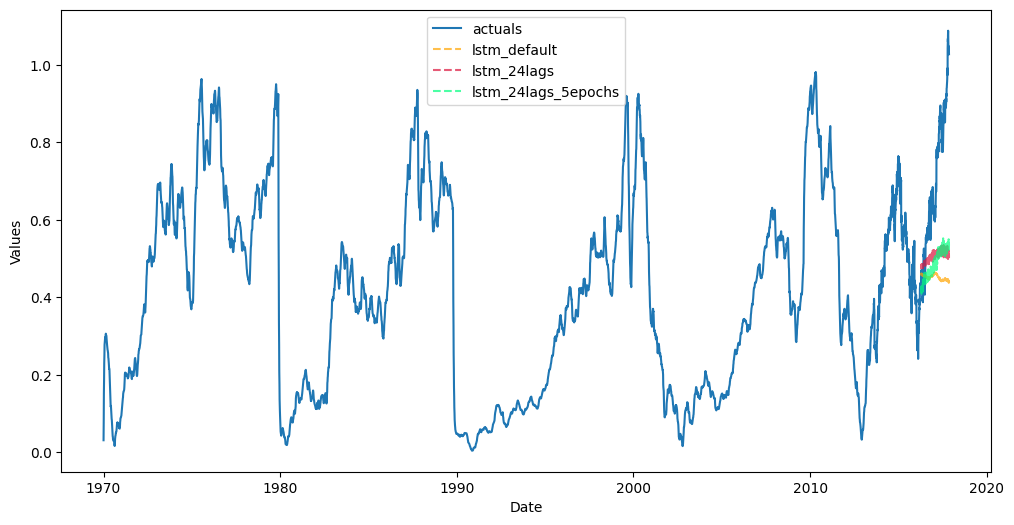

In [28]:
f.manual_forecast(
    call_me='lstm_24lags_5epochs',
    lags=24,
    epochs=5,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

Epoch 1/25
282/282 [==============================] - 11s 13ms/step - loss: 0.1612 - val_loss: 0.1608
Epoch 2/25
282/282 [==============================] - 3s 9ms/step - loss: 0.1244 - val_loss: 0.1568
Epoch 3/25
282/282 [==============================] - 3s 9ms/step - loss: 0.1228 - val_loss: 0.1566
Epoch 4/25
282/282 [==============================] - 4s 13ms/step - loss: 0.1222 - val_loss: 0.1568
Epoch 5/25
282/282 [==============================] - 4s 16ms/step - loss: 0.1225 - val_loss: 0.1663
Epoch 6/25
282/282 [==============================] - 3s 9ms/step - loss: 0.1222 - val_loss: 0.1645
Epoch 7/25
282/282 [==============================] - 3s 10ms/step - loss: 0.1215 - val_loss: 0.1583
Epoch 8/25
282/282 [==============================] - 3s 10ms/step - loss: 0.1213 - val_loss: 0.1536
Epoch 9/25
282/282 [==============================] - 4s 12ms/step - loss: 0.1213 - val_loss: 0.1593
Epoch 10/25
282/282 [==============================] - 3s 11ms/step - loss: 0.1213 - val_loss

/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

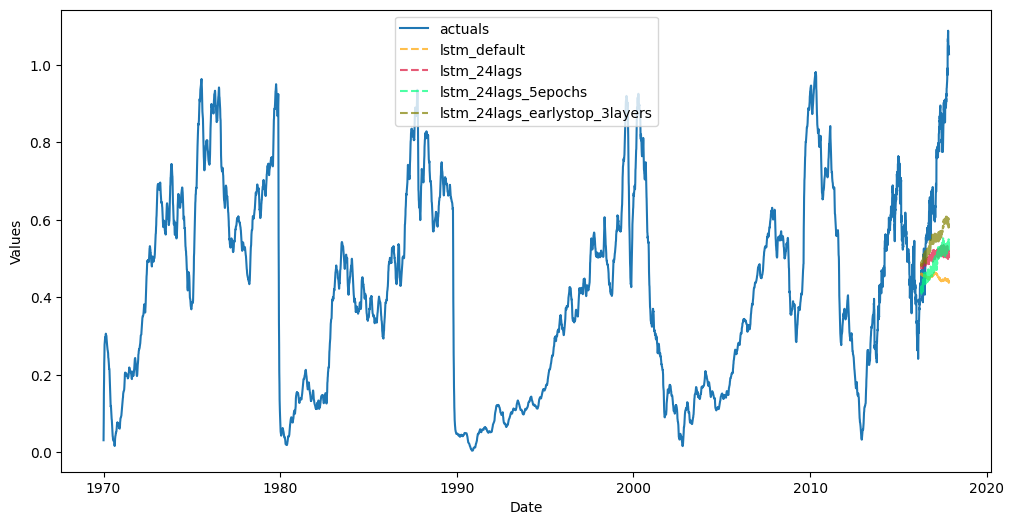

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0),
)

f.plot_test_set(ci=True)

Epoch 1/15
281/281 [==============================] - 11s 18ms/step - loss: 0.1394 - val_loss: 0.1595
Epoch 2/15
281/281 [==============================] - 5s 17ms/step - loss: 0.1260 - val_loss: 0.1556
Epoch 3/15
281/281 [==============================] - 4s 13ms/step - loss: 0.1261 - val_loss: 0.1535
Epoch 4/15
281/281 [==============================] - 4s 13ms/step - loss: 0.1238 - val_loss: 0.1543
Epoch 5/15
281/281 [==============================] - 4s 14ms/step - loss: 0.1219 - val_loss: 0.1534
Epoch 6/15
281/281 [==============================] - 5s 16ms/step - loss: 0.1214 - val_loss: 0.1566
Epoch 7/15
281/281 [==============================] - 4s 13ms/step - loss: 0.1215 - val_loss: 0.1606
Epoch 8/15
281/281 [==============================] - 4s 14ms/step - loss: 0.1207 - val_loss: 0.1697
Epoch 9/15
281/281 [==============================] - 5s 18ms/step - loss: 0.1192 - val_loss: 0.1586
Epoch 10/15
281/281 [==============================] - 4s 15ms/step - loss: 0.1180 - val_l

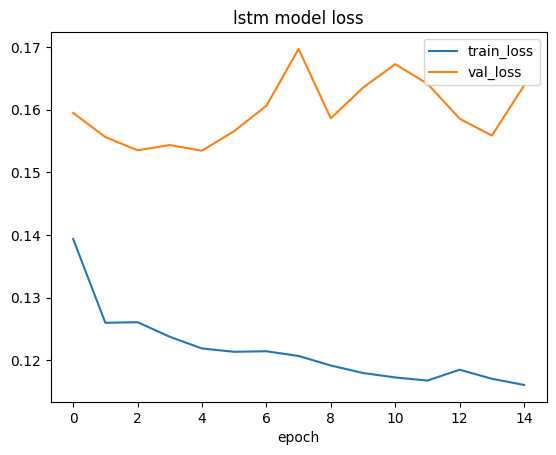

Epoch 1/15
291/291 [==============================] - 12s 18ms/step - loss: 0.1260 - val_loss: 0.1540
Epoch 2/15
291/291 [==============================] - 5s 18ms/step - loss: 0.1112 - val_loss: 0.1581
Epoch 3/15
291/291 [==============================] - 4s 13ms/step - loss: 0.1100 - val_loss: 0.1533
Epoch 4/15
291/291 [==============================] - 8s 29ms/step - loss: 0.1090 - val_loss: 0.1528
Epoch 5/15
291/291 [==============================] - 7s 25ms/step - loss: 0.1088 - val_loss: 0.1518
Epoch 6/15
291/291 [==============================] - 4s 13ms/step - loss: 0.1077 - val_loss: 0.1467
Epoch 7/15
291/291 [==============================] - 11s 36ms/step - loss: 0.1066 - val_loss: 0.1484
Epoch 8/15
291/291 [==============================] - 4s 13ms/step - loss: 0.1055 - val_loss: 0.1462
Epoch 9/15
291/291 [==============================] - 4s 13ms/step - loss: 0.1061 - val_loss: 0.1496
Epoch 10/15
291/291 [==============================] - 5s 17ms/step - loss: 0.1054 - val_

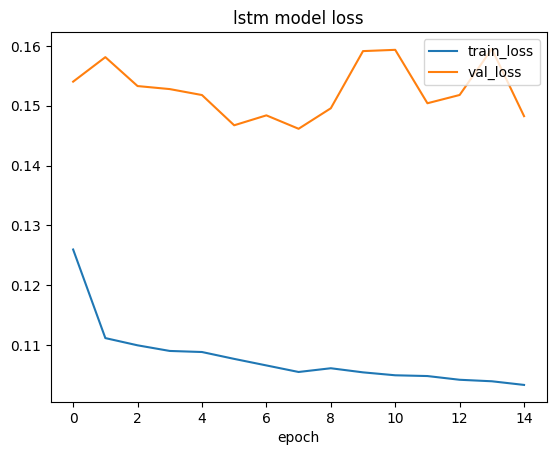

In [30]:
f.manual_forecast(
    call_me='lstm_best',
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True
)

/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scalecast/_utils.py:60: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

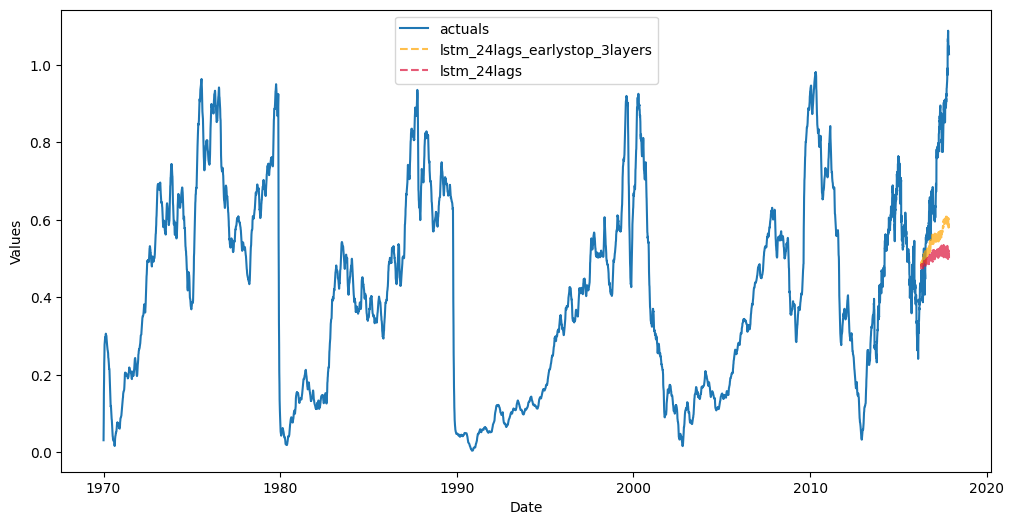

In [31]:
f.plot_test_set(order_by='TestSetMAPE',models='top_2',ci=True)

## MLR

In [32]:
transformer = SeriesTransformer(f)
f = transformer.DiffTransform()

f.add_ar_terms(24)
f.add_seasonal_regressors('month','quarter',dummy=True)
f.add_seasonal_regressors('year')
f.add_time_trend()

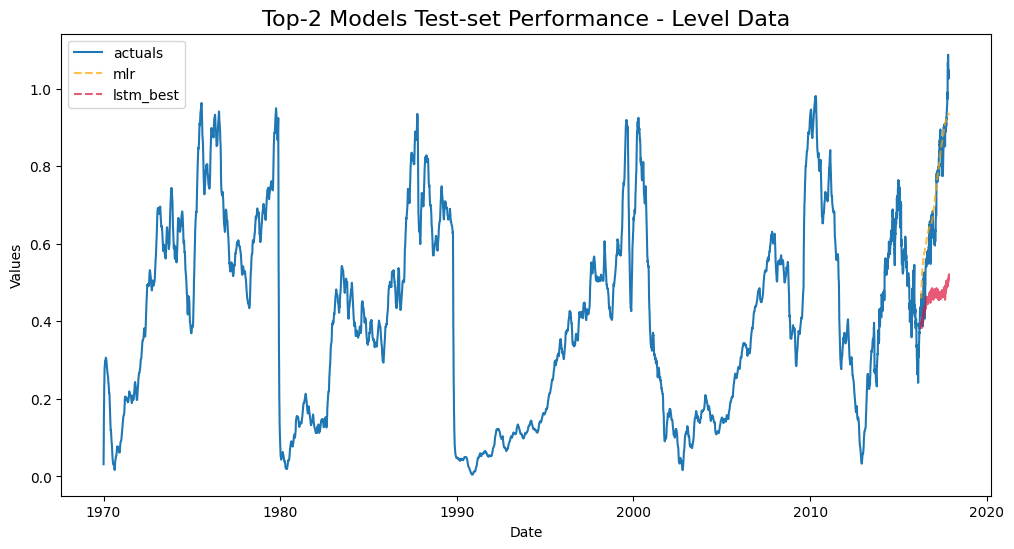

In [33]:
f.set_estimator('mlr')
f.manual_forecast()

f = transformer.DiffRevert(
    exclude_models = [m for m in f.history if m != 'mlr']
) # exclude all lstm models from the revert

f.plot_test_set(order_by='TestSetMAPE',models=['lstm_best','mlr'])
plt.title('Top-2 Models Test-set Performance - Level Data',size=16)
plt.show()

## We plot the predictions for both models and export them with some metrics.

<Axes: xlabel='Date', ylabel='Values'>

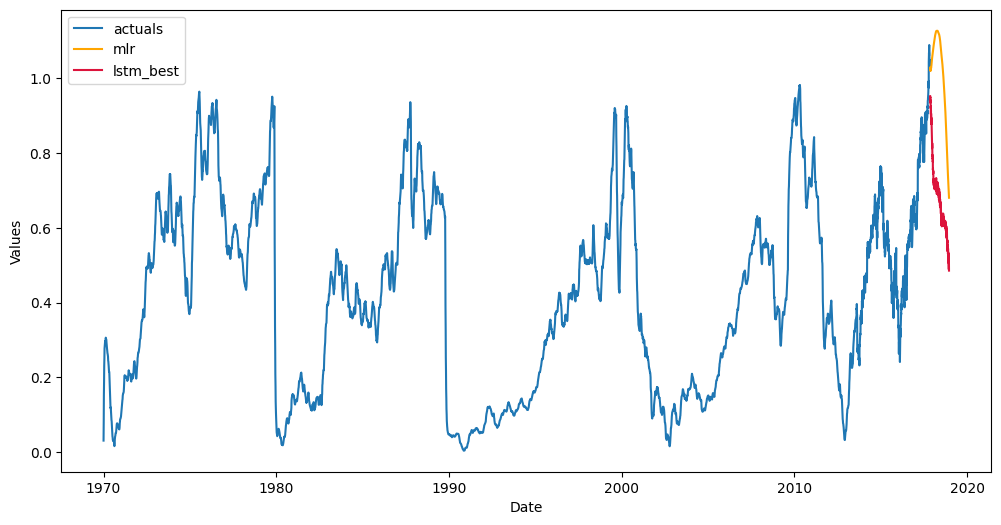

In [36]:
f.plot(
    models=['mlr','lstm_best'],
    order_by='TestSetMAPE'
)

In [39]:
f.export('model_summaries',determine_best_by='TestSetMAPE')[
    ['ModelNickname',
     'TestSetMAPE',
     'TestSetRMSE',
     'TestSetR2',
     'best_model']
]

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model
0,mlr,0.088357,0.066794,0.855062,True
1,lstm_24lags_earlystop_3layers,0.215229,0.214308,-0.492043,False
2,lstm_24lags,0.264704,0.258965,-1.178660,False
3,lstm_24lags_5epochs,0.282811,0.260166,-1.198901,False
4,lstm_best,0.311962,0.288602,-1.705858,False
5,lstm_default,0.329909,0.311811,-2.158567,False
